In [1]:
# !conda uninstall tokenizers, transformers
!pip install transformers
!pip install nltk

# Imports

In [2]:
import os
import nltk
import pandas as pd
from tqdm.auto import tqdm

from datasets import Dataset
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer



Let's take a quick glance at the `train.csv` file:

In [3]:
# Constants
TRAIN_CSV = "../input/feedback-prize-2021/train.csv"
SUB_CSV = "../input/feedback-prize-2021/sample_submission.csv"
TRAIN_PATH = "../input/feedback-prize-2021/train"
TEST_PATH = "../input/feedback-prize-2021/test"

# Load DF
df = pd.read_csv(TRAIN_CSV, dtype={'discourse_id': int, 'discourse_start': int, 'discourse_end': int})
df.head()

id   discourse_id  discourse_start  discourse_end  \
0  423A1CA112E2  1622627660524                8            229   
1  423A1CA112E2  1622627653021              230            312   
2  423A1CA112E2  1622627671020              313            401   
3  423A1CA112E2  1622627696365              402            758   
4  423A1CA112E2  1622627759780              759            886   

                                      discourse_text discourse_type  \
0  Modern humans today are always on their phone....           Lead   
1  They are some really bad consequences when stu...       Position   
2  Some certain areas in the United States ban ph...       Evidence   
3  When people have phones, they know about certa...       Evidence   
4  Driving is one of the way how to get around. P...          Claim   

  discourse_type_num                                   predictionstring  
0             Lead 1  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...  
1         Position 1       45 46 47 48 49 50 51 52 53 54 55 56 57 58 59  
2         Evidence 1    60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75  
3         Evidence 2  76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...  
4            Claim 1  139 140 141 142 143 144 145 146 147 148 149 15...

From the [Data tab](https://www.kaggle.com/c/feedback-prize-2021/data):

* id - ID code for essay response
* discourse_id - ID code for discourse element
* discourse_start - character position where discourse element begins in the essay response
* discourse_end - character position where discourse element ends in the essay response
* discourse_text - text of discourse element
* discourse_type - classification of discourse element
* discourse_type_num - enumerated class label of discourse element
* predictionstring - the word indices of the training sample, as required for predictions


In [4]:
# No nulls
df.isnull().sum()

id                    0
discourse_id          0
discourse_start       0
discourse_end         0
discourse_text        0
discourse_type        0
discourse_type_num    0
predictionstring      0
dtype: int64

## Let's see the first example in some more detail

In [5]:
a_id = "423A1CA112E2"

In [6]:
def get_text(a_id):
    a_file = f"{TRAIN_PATH}/{a_id}.txt"
    with open(a_file, "r") as fp:
        txt = fp.read()
    return txt

txt = get_text(a_id)
print(txt)

Phones

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.

When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.

Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. S

In [7]:
df_example = df[df['id'] == a_id]
df_example

id   discourse_id  discourse_start  discourse_end  \
0  423A1CA112E2  1622627660524                8            229   
1  423A1CA112E2  1622627653021              230            312   
2  423A1CA112E2  1622627671020              313            401   
3  423A1CA112E2  1622627696365              402            758   
4  423A1CA112E2  1622627759780              759            886   
5  423A1CA112E2  1622627780655              887           1150   
6  423A1CA112E2  1622627811787             1151           1533   
7  423A1CA112E2  1622627585180             1534           1602   
8  423A1CA112E2  1622627895668             1603           1890   
9  423A1CA112E2  1622627628524             1891           2027   

                                      discourse_text        discourse_type  \
0  Modern humans today are always on their phone....                  Lead   
1  They are some really bad consequences when stu...              Position   
2  Some certain areas in the United States ban ph...              Evidence   
3  When people have phones, they know about certa...              Evidence   
4  Driving is one of the way how to get around. P...                 Claim   
5  That's why there's a thing that's called no te...              Evidence   
6  Sometimes on the news there is either an accid...              Evidence   
7  Phones are fine to use and it's also the best ...                 Claim   
8  If you go through a problem and you can't find...              Evidence   
9  The news always updated when people do somethi...  Concluding Statement   

       discourse_type_num                                   predictionstring  
0                  Lead 1  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...  
1              Position 1       45 46 47 48 49 50 51 52 53 54 55 56 57 58 59  
2              Evidence 1    60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75  
3              Evidence 2  76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...  
4                 Claim 1  139 140 141 142 143 144 145 146 147 148 149 15...  
5              Evidence 3  163 164 165 166 167 168 169 170 171 172 173 17...  
6              Evidence 4  211 212 213 214 215 216 217 218 219 220 221 22...  
7                 Claim 2  282 283 284 285 286 287 288 289 290 291 292 29...  
8              Evidence 5  297 298 299 300 301 302 303 304 305 306 307 30...  
9  Concluding Statement 1  355 356 357 358 359 360 361 362 363 364 365 36...

In [8]:
# Files in train path: 15595
!ls -l {TRAIN_PATH} | wc -l

15595


In [9]:
# Files in test path: 6
!ls -l {TEST_PATH} | wc -l

6


I will stop with the EDA here because I have already seen various very good notebooks around, against which I cannot offer much value. I suggest you the following ones:

* [Feedback Prize EDA with displacy](https://www.kaggle.com/thedrcat/feedback-prize-eda-with-displacy) by [thedrcat](https://www.kaggle.com/thedrcat/)
* [[Feedback prize] Simple EDA](https://www.kaggle.com/ilialar/feedback-prize-simple-eda) by [ilialar](https://www.kaggle.com/ilialar)
* [🔥📊 Feedback Prize - EDA 📊🔥](https://www.kaggle.com/odins0n/feedback-prize-eda) by [odins0n](https://www.kaggle.com/odins0n/)
* [Feedback Prize - EDA](https://www.kaggle.com/yamqwe/feedback-prize-eda) by [yamqwe](https://www.kaggle.com/yamqwe/)


Let's get into the sentence classification idea!


# Sentence Classifier

# Create a sentence classification dataset

There are 7 classes and the labeled sections (sometimes) exceed sentences. We will preprocess them to have only sentences. That way, we will avoid the problem of detecting when an element starts and when it ends (for now).


In [10]:
# There are 7 classes:
df['discourse_type'].value_counts(normalize=True)

Claim                   0.347959
Evidence                0.316731
Position                0.106859
Concluding Statement    0.093594
Lead                    0.064487
Counterclaim            0.040314
Rebuttal                0.030057
Name: discourse_type, dtype: float64

## Encode classes as ints
Some sections don't belong to any class. We will label them as `No Class` so we can discard those sections and avoid false positives.

In [11]:
ID2CLASS = dict(enumerate(df['discourse_type'].unique().tolist() + ['No Class']))
CLASS2ID = {v: k for k, v in ID2CLASS.items()}
print(ID2CLASS)
CLASS2ID

{0: 'Lead', 1: 'Position', 2: 'Evidence', 3: 'Claim', 4: 'Concluding Statement', 5: 'Counterclaim', 6: 'Rebuttal', 7: 'No Class'}


{'Lead': 0,
 'Position': 1,
 'Evidence': 2,
 'Claim': 3,
 'Concluding Statement': 4,
 'Counterclaim': 5,
 'Rebuttal': 6,
 'No Class': 7}

## Dataset functions: `fill_gaps()`, `get_elements()`, and `get_x_samples()`

Here we write the following functions:
* `fill_gaps()`,  which will label the "No Class" parts of the texts. 
* `get_elements()`, which uses `fill_gaps` and creates a list of text sections for a given text id 
* `get_x_samples()`, which maps these elements into sentences with labels.

First you'll find the code used for development (because it illustrates the thought process) and below you'll find the condensed functions.

In [12]:
text_ids = df['id'].unique().tolist()

In [13]:
text_id = text_ids[5]
text = get_text(text_id)
print(text)

Operating a motor vehicle while on your cell phone

Being on your device and driving could be an overly dangerous choice in life. Many people around the world are injured by this situation every day. It could lead to accidents and altercations. In addition it would even cost you your licences. The most detrimental outcome is death. There are far more outcomes to operating a motor vehicle while being on a cell phone. Drivers should not be able to use cell phones in any capacity while operating a motor vehicle.

One leading cause to motor vehicle accidents is being on your cell phone. It could lead to accidents and altercations. Yourself and the passengers are more at risk to bodily injuries and harm. These bodily injuries and harm can range anywhere from mild to critical condition. In an motor vehicle accident there is more than one involved. There is another person or group of people that could have the exact same conditions than the driver on the cell phone. In an example of an alterc

In [14]:
# Extract element boundaries and classes with to_records

df_text = df[df['id'] == text_id]
elements = df_text[['discourse_start', 'discourse_end', 'discourse_type']].to_records(index=False).tolist()
elements

[(52, 200, 'Lead'),
 (200, 244, 'Claim'),
 (245, 294, 'Claim'),
 (295, 334, 'Claim'),
 (418, 515, 'Position'),
 (516, 590, 'Claim'),
 (590, 1152, 'Evidence'),
 (1162, 1219, 'Claim'),
 (1220, 1706, 'Evidence'),
 (1718, 1842, 'Claim'),
 (1843, 2443, 'Evidence'),
 (2444, 2922, 'Concluding Statement')]

In [15]:
# Fill "No class" chunks: beginning and end

initial_idx = 0
final_idx = len(text)

# Add element at the beginning if it doesn't in index 0
new_elements = []
if elements[0][0] != initial_idx:
    starting_element = (0, elements[0][0]-1, 'No Class')
    new_elements.append(starting_element)

    
# Add element at the end if it doesn't in index "-1"
if elements[-1][1] != final_idx:
    closing_element = (elements[-1][1]+1, final_idx, 'No Class')
    new_elements.append(closing_element)
    
elements += new_elements
elements = sorted(elements, key=lambda x: x[0])

# See the first element (it's new, labeled "No Class")
elements

[(0, 51, 'No Class'),
 (52, 200, 'Lead'),
 (200, 244, 'Claim'),
 (245, 294, 'Claim'),
 (295, 334, 'Claim'),
 (418, 515, 'Position'),
 (516, 590, 'Claim'),
 (590, 1152, 'Evidence'),
 (1162, 1219, 'Claim'),
 (1220, 1706, 'Evidence'),
 (1718, 1842, 'Claim'),
 (1843, 2443, 'Evidence'),
 (2444, 2922, 'Concluding Statement')]

In [16]:
# Add "No class" elements inbetween separated elements 
new_elements = []
for i in range(1, len(elements)-1):
    if elements[i][0] != elements[i-1][1] + 1 and elements[i][0] != elements[i-1][1]:
        new_element = (elements[i-1][1] + 1, elements[i][0]-1, 'No Class')
        new_elements.append(new_element)

elements += new_elements
elements = sorted(elements, key=lambda x: x[0])
elements

[(0, 51, 'No Class'),
 (52, 200, 'Lead'),
 (200, 244, 'Claim'),
 (245, 294, 'Claim'),
 (295, 334, 'Claim'),
 (335, 417, 'No Class'),
 (418, 515, 'Position'),
 (516, 590, 'Claim'),
 (590, 1152, 'Evidence'),
 (1153, 1161, 'No Class'),
 (1162, 1219, 'Claim'),
 (1220, 1706, 'Evidence'),
 (1707, 1717, 'No Class'),
 (1718, 1842, 'Claim'),
 (1843, 2443, 'Evidence'),
 (2444, 2922, 'Concluding Statement')]

In [17]:
# Final "fill_gaps" functions, wrapping up the above cells

def fill_gaps(elements, text):
    """Add "No Class" elements to a list of elements (see get_elements) """
    initial_idx = 0
    final_idx = len(text)

    # Add element at the beginning if it doesn't in index 0
    new_elements = []
    if elements[0][0] != initial_idx:
        starting_element = (0, elements[0][0]-1, 'No Class')
        new_elements.append(starting_element)


    # Add element at the end if it doesn't in index "-1"
    if elements[-1][1] != final_idx:
        closing_element = (elements[-1][1]+1, final_idx, 'No Class')
        new_elements.append(closing_element)

    elements += new_elements
    elements = sorted(elements, key=lambda x: x[0])

    # Add "No class" elements inbetween separated elements 
    new_elements = []
    for i in range(1, len(elements)-1):
        if elements[i][0] != elements[i-1][1] + 1 and elements[i][0] != elements[i-1][1]:
            new_element = (elements[i-1][1] + 1, elements[i][0]-1, 'No Class')
            new_elements.append(new_element)

    elements += new_elements
    elements = sorted(elements, key=lambda x: x[0])
    return elements


def get_elements(df, text_id, do_fill_gaps=True, text=None):
    """Get a list of (start, end, class) elements for a given text_id"""
    text = get_text(text_id) if text is None else text
    df_text = df[df['id'] == text_id]
    elements = df_text[['discourse_start', 'discourse_end', 'discourse_type']].to_records(index=False).tolist()
    if do_fill_gaps:
        elements = fill_gaps(elements, text)
    return elements

In [18]:
def get_x_samples(df, text_id, do_fill_gaps=True):
    """Create a dataframe of the sentences of the text_id, with columns text, label """
    text = get_text(text_id)
    elements = get_elements(df, text_id, do_fill_gaps, text)
    sentences = []
    for start, end, class_ in elements:
        elem_sentences = nltk.sent_tokenize(text[start:end])
        sentences += [(sentence, class_) for sentence in elem_sentences]
    df = pd.DataFrame(sentences, columns=['text', 'label'])
    df['label'] = df['label'].map(CLASS2ID)
    return df

get_x_samples(df, text_ids[1])

text  label
0                                    Phones & Driving      7
1   Drivers should not be able to use phones while...      1
2   Drivers who used their phone while operating a...      3
3   According to an article by the Edgar Snyder Fi...      2
4   According to the same article, 35% know the ri...      2
5   This shows that its beyond dangerous and irres...      2
6   Drivers should be able to concentrate without ...      2
7   According to another article, "Distracted Driv...      2
8   The article states that teen get too distracte...      2
9   Accidents that can be easily avoided by focusi...      2
10  Drivers should not be able to use their phones...      2
11  In conclusion, drivers should not able to work...      4
12  Drivers who uses their phones while operating ...      4

## Build the full dataframe for sentence classification

In [19]:
# This takes a while. I created a dataset with the output here: https://www.kaggle.com/julian3833/feedback-df-sentences
#x = []
#for text_id in tqdm(text_ids):
#    x.append(get_x_samples(df, text_id))

#df_sentences = pd.concat(x)

In [20]:
df_sentences = pd.read_csv("../input/feedback-df-sentences/df_sentences.csv")

In [21]:
df_sentences = df_sentences[df_sentences.text.str.split().str.len() >= 3]
df_sentences.head()

text  label
0     Modern humans today are always on their phone.      0
1  They are always on their phone more than 5 hou...      0
2                     They even do it while driving.      0
3  They are some really bad consequences when stu...      1
4  Some certain areas in the United States ban ph...      2

In [22]:
df_sentences.to_csv("df_sentences.csv", index=False)

In [23]:
len(df_sentences)

348053

# Modeling!!!

We will use a `BERT` and the `Trainer` API from Hugging Face. 

We are using a dataset to avoid using Internet (this is because submissions notebooks should not have Internet access: a competition restriction).

References:
* https://huggingface.co/docs/transformers/training
* https://huggingface.co/docs/transformers/custom_datasets

In [24]:
MODEL_CHK = "../input/huggingface-bert/bert-base-cased"

NUM_LABELS = 8

NUM_EPOCHS = 3

## HuggingFace Dataset

In [25]:
ds_train = Dataset.from_pandas(df_sentences.iloc[:340000])
ds_val = Dataset.from_pandas(df_sentences.iloc[340000:])

## Tokenize

In [26]:
transformers.logging.set_verbosity_warning() # Silence some annoying logging of HF

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHK)

def preprocess_function(examples):    
    return tokenizer(examples["text"], truncation=True, max_length=326)


# Tokenizer dataset
ds_train_tokenized = ds_train.map(preprocess_function, batched=True)
ds_val_tokenized = ds_val.map(preprocess_function, batched=True)

  0%|          | 0/340 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

In [27]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHK, num_labels=NUM_LABELS)

Some weights of the model checkpoint at ../input/huggingface-bert/bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from

### Prepare trainer

In [28]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['WANDB_DISABLED'] = 'true'

training_args = TrainingArguments(
    output_dir='feeeback-classifier',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    report_to="none",
    evaluation_strategy="epoch",
    save_strategy="epoch",

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train_tokenized,
    eval_dataset=ds_val_tokenized,
    tokenizer=tokenizer,
    #data_collator=data_collator,
)

## Train

In [29]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=15939, training_loss=0.9924423109595812, metrics={'train_runtime': 7918.8944, 'train_samples_per_second': 128.806, 'train_steps_per_second': 2.013, 'total_flos': 3.639322874406758e+16, 'train_loss': 0.9924423109595812, 'epoch': 3.0})

In [ ]:
trainer.save_model("feedback-bert-trained")

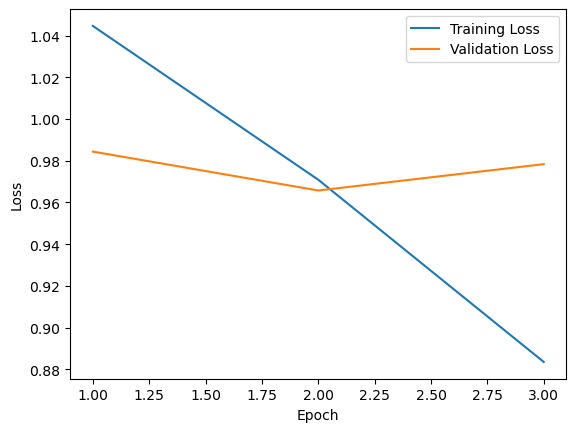

In [5]:
import matplotlib.pyplot as plt
x=[1,2,3]
y1=[1.044700,0.970900,0.883500]
y2=[0.984407,0.965756,0.978382]
plt.plot(x, y1, label = "Training Loss")
plt.plot(x, y2, label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Drop "No class" sentences
df_test = df_test[df_test['class'] != 'No Class']
df_test.head()

In [ ]:
# And submit!! 🤞🤞 
df_test[['id', 'class', 'predictionstring']].to_csv("submission.csv", index=False)